In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def bacteria(params, uc):
    a, b, g, u_thresh, n = params
    return a + ((b * np.power(uc, n)) / (np.power(u_thresh, n) + np.power(uc, n))) - (g * uc)

In [3]:
def bacteria_particle(params, uc, ue, d1, d2, cells):
    duc = (bacteria(params, uc) + d1 * ue - d2 * uc) * cells
    due = (-d1 * ue + d2 * uc) * cells
    return duc, due

In [4]:
def verlet(x, y, r, e):
    neighbors = np.zeros((50, 50), dtype = 'object')
    kernel = np.zeros((50, 50), dtype = 'object')
    dim = np.shape(x)
    for i in range(dim[0]):
        for j in range(dim[1]):
            dist = np.sqrt(np.square(x[i,j] - x) + np.square(y[i,j] - y))
            neighbors[i, j] = np.transpose(np.where(dist <= r))
            kernel[i, j] = (1 / (4 * (np.pi * np.square(e)))) * np.exp(-(np.square(dist[dist <= r]) / (4 * np.square(e))))
    return neighbors, kernel

In [5]:
#nest=np.array([x, y, uc, ue, cells, neighbors, kernel]) 

def pse(nest, De, Vp, ge, e):
    k_sum = np.zeros((50, 50))
    dim = np.shape(nest)
    for i in range(dim[1]):
        for j in range(dim[2]):
            k_sum[i, j] = np.sum((np.array([nest[3][k[0], k[1]] for k in nest[5][i, j]]) - nest[3][i, j]) * nest[6][i, j]) 
    due_diff = k_sum * Vp * De / np.square(e)
    due_deg = -ge * nest[3]
    return due_diff + due_deg

In [6]:
def advection(x, y, dt):
    v = np.array([4 * (1 - np.cos(2 * math.pi * y.astype('float') / 50)), 3])
    adv_x = x + dt * v[0]
    adv_y = y + dt * v[1]
    return adv_x, adv_y

In [7]:
def piecewise(sx, sy):
    Ax = np.select([(sx >= 0) & (sx < 1),(sx >= 1) & (sx < 2), (sx >= 2)],
                     [1 - 0.5 * (5 * np.square(sx) - 3 * np.power(sx,3)),0.5 * np.square(2-sx) * (1 - sx),0])
    Ay = np.select([(sy >= 0) & (sy < 1),(sy >= 1) & (sy < 2), (sy >= 2)],
                     [1 - 0.5 * (5 * np.square(sy) - 3 * np.power(sy,3)),0.5 * np.square(2-sy) * (1 - sy),0])
    return Ax, Ay

In [8]:
def piecewise_2(sx, sy):
    Ax = np.piecewise(sx, [(sx >= 0) & (sx < 1),(sx >= 1) & (sx < 2), (sx >= 2)],
                     [lambda sx_f: 1 - 0.5 * (5 * np.square(sx_f) - 3 * np.power(sx_f,3)), lambda sx_f: 0.5 * np.square(2-sx_f) * (1 - sx_f), lambda sx_f: 0])
    Ay = np.piecewise(sx, [(sy >= 0) & (sy < 1),(sy >= 1) & (sy < 2), (sy >= 2)],
                     [lambda sy_f: 1 - 0.5 * (5 * np.square(sy_f) - 3 * np.power(sy_f,3)), lambda sy_f: 0.5 * np.square(2-sy_f) * (1 - sy_f), lambda sy_f: 0])
    return Ax, Ay

In [9]:
def assignment(x, y, adv_x, adv_y):
    sx = np.absolute(adv_x - x)
    sy = np.absolute(adv_y - y)
    return sx, sy

In [10]:
def remeshing(nest, adv_x, adv_y):
    grid_ue = np.zeros((50,50))
    dim = np.shape(grid_ue)
    for i in range(dim[0]):
        for j in range(dim[1]):
            sx, sy = assignment(nest[0][i,j], nest[1][i,j], adv_x, adv_y)
            Ax, Ay = piecewise(sx, sy)
            grid_ue[i, j] = np.sum(Ax * Ay * nest[3])
    return grid_ue

In [11]:
def remeshing_2(nest, adv_x, adv_y):
    sx = np.absolute(adv_x[:, :, np.newaxis] - nest[0].flatten())
    sy = np.absolute(adv_y[:, :, np.newaxis] - nest[1].flatten())
    Ax, Ay = piecewise_2(sx, sy)
    A = Ax * Ay
    #grid_ue = np.sum((A * nest[3][:,:,np.newaxis]), axis=2)
    grid_ue = np.sum(np.sum((A * nest[3][:,:,np.newaxis]),axis=1).transpose(),axis=1).reshape(50,50)
    return grid_ue

In [12]:
def plot_state(x, y, z1, z2, z3, count, save):
    plt.figure(figsize=(18, 4))
    titles=['uc','ue','cells']
    for idx, z in enumerate([z1, z2, z3]):
        plt.subplot(1, 3, idx+1)
        plt.scatter(x, y, c=z, s=15)
        plt.title(titles[idx], size=15)
        plt.colorbar()
    if save == 'save':
        plt.savefig('out_' + str(count) + '.png')
    else:
        plt.show()
    return   

In [20]:
params=np.array([1, 100, 0.1, 1, 10])           # rxn paramerters: a, b, g, u_thresh, n
De = 1                                          # diffusion coefficient of ue
d1 = 0.25
d2 = 2.5
ge = 0                                          # external degradation of AHL
T = 1                                           # max time
h = 1                                           # particle spacing
Vp = h ** 2
dt = (h ** 2)/((4 * De)*2)                      # time step
e = h                                           # kernel width
r = np.sqrt(2)                                  # radius of interaction
particles = np.arange(0+(h/2),51-(h/2),h)       # create mesh of particles
x, y = np.meshgrid(particles, particles)
uc, ue = np.zeros((50, 50)), np.zeros((50, 50)) # initial concentrations
cells = np.zeros((50, 50))                      # bacterium count in each particle
cells[24, 24] = 1                               # add a bacterium in the grid
cells[20, 20] = 1
cells[32, 26] = 1
cells[35, 30] = 1
cells[24, 26] = 1
cells[25, 31] = 1
cells[27, 26] = 1
cells[18, 40] = 1
cells[30, 35] = 1
uc[24, 24] = 150                                # initial AHL concentration of bacteria in center

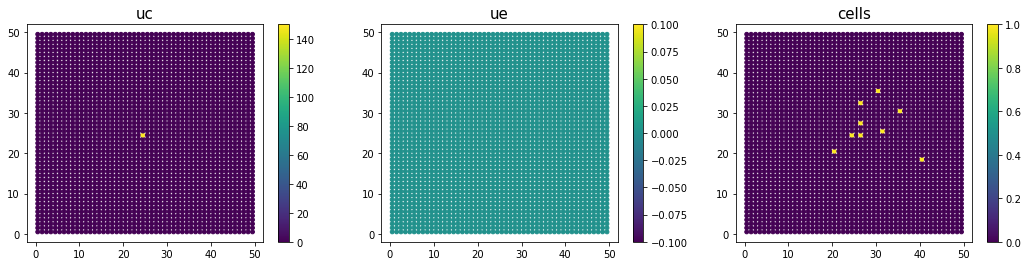

In [21]:
neighbors, kernel = verlet(x, y, r, e)                     # get neighbor and kernel array
nest=np.array([x, y, uc, ue, cells, neighbors, kernel])    # compile verlet list
plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], 0, 'show') # plot initial state

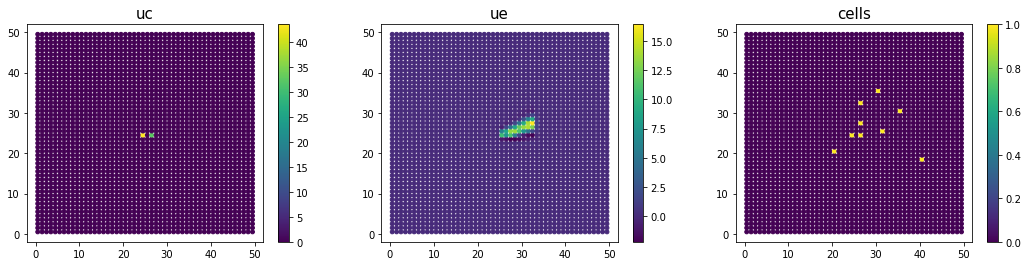

In [15]:
from timeit import default_timer as timer
start = timer()

t = 0
count = 0
while t < T:
    due_e = pse(nest, De, Vp, ge, e) * dt
    duc_b, due_b = bacteria_particle(params, nest[2], nest[3], d1, d2, nest[4])
    duc_b = duc_b * dt
    due_b = due_b * dt
    nest[2] = nest[2] + duc_b
    nest[3] = nest[3] + due_e + due_b
    adv_x, adv_y = advection(nest[0], nest[1], dt)
    nest[3] = remeshing(nest, adv_x, adv_y)
    t = t + dt
    #plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], count, 'save')
    count = count + 1
    
plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], 0, 'show')

end = timer()
print("%.2f seconds" % (end - start))

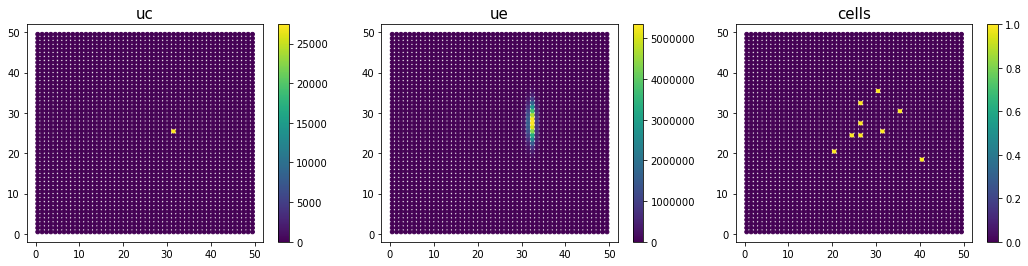

29.32 seconds


In [22]:
from timeit import default_timer as timer
start = timer()

t = 0
count = 0
while t < T:
    due_e = pse(nest, De, Vp, ge, e) * dt
    duc_b, due_b = bacteria_particle(params, nest[2], nest[3], d1, d2, nest[4])
    duc_b = duc_b * dt
    due_b = due_b * dt
    nest[2] = nest[2] + duc_b
    nest[3] = nest[3] + due_e + due_b
    adv_x, adv_y = advection(nest[0], nest[1], dt)
    nest[3] = remeshing_2(nest, adv_x, adv_y)
    t = t + dt
    #plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], count, 'save')
    count = count + 1
    
plot_state(nest[0], nest[1], nest[2], nest[3], nest[4], 0, 'show')

end = timer()
print("%.2f seconds" % (end - start))